In [1]:

import pandas as pd
import numpy as np
import torch

from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition import PosteriorMean
from botorch.optim.optimize import optimize_acqf
import numpy as np
from scipy.spatial.distance import cdist
from botorch import fit_gpytorch_mll
torch.set_printoptions(precision=12, sci_mode=False)
import copy

def covSEard(hyp, x, z):
    """
    ARD covariance:
        x is of dimension n X D
        y is of dimension m X D
    """
    hyp = np.exp(hyp)

    D = x.shape[1]
    X = (1 / hyp[:D]) * x

    Z = (1 / hyp[:D]) * z
    K = cdist(X, Z)

    K = hyp[D] ** 2 * np.exp(-K ** 2 / 2)

    return K

def rkhs_synth(x):
    """
    RKHS Function
        Description: Synthetic heteroscedastic function generated from 2 Squared Exponential kernels
                     for Bayesian Optimization method evaluation tasks
        Evaluated: x \in [0,1]
        Global Maximum: x=0.89235, f(x)=5.73839
        Authors: Ziyu Wang, John Assael and Nando de Freitas
    """

    x = np.atleast_2d(x)
    hyp_1 = np.log(np.array([0.1, 1]))
    hyp_2 = np.log(np.array([0.01, 1]))

    support_1 = [0.1, 0.15, 0.08, 0.3, 0.4]
    support_2 = [0.8, 0.85, 0.9, 0.95, 0.92, 0.74, 0.91, 0.89, 0.79, 0.88, 0.86, 0.96, 0.99, 0.82]
    vals_1 = [4, -1, 2., -2., 1.]
    vals_2 = [3, 4, 2, 1, -1, 2, 2, 3, 3, 2., -1., -2., 4., -3.]

    f = sum([vals_2[i] * covSEard(hyp_2, np.atleast_2d(np.array(s)), x) for i, s in enumerate(support_2)])
    f += sum([vals_1[i] * covSEard(hyp_1, np.atleast_2d(np.array(s)), x) for i, s in enumerate(support_1)])

    return float(f)

In [2]:
import random
import time

def setUpSampleSpace(spaceSize=100):
    Xpr = [random.random() for i in range(spaceSize)]
    
    domain = []
    for x in Xpr:
       domain.append( [x, 1.0, rkhs_synth(x)])
       domain.append( [x, 0.5, rkhs_synth(x) + random.gauss(0, 1)])
    
    domain = np.array(domain)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fileName = 'SampleSpaces/'+timestr + '.csv'
    np.savetxt(fileName, domain, delimiter=',')

    return fileName

def setUpInitialData(sampleSpaceName, initialSize=10):
   sampleSpace = np.loadtxt(sampleSpaceName, delimiter=',')
   size = len(sampleSpace) 
   index_store = random.sample(range(size), initialSize)
   budget = sampleSpace[index_store, 1]
   train_X = sampleSpace[index_store, :-1]
   train_obj = sampleSpace[index_store, -1:]
   return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, index_store, budget.flatten().tolist()

In [3]:
# file = setUpSampleSpace(100)
# train_X, train_obj, domain, index_store, budget = setUpInitialData(file, 10)
# print(budget)

In [3]:
def runMes(model, Xrpr):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    candidate_set = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(10000, 1)
    target_fidelities = {1: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={1: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    acquisition = qMultiFidelityMaxValueEntropy(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            candidate_set=candidate_set,
        )
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]))
    return acquisitionScores

In [4]:
def runKG(model, Xrpr):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    target_fidelities = {1: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={1: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=Xrpr.shape[1],
        columns=[Xrpr.shape[1]-1],
        values=[1],
    )                
    _, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:,:-1],
        q=1,
        num_restarts= 2,
        raw_samples=4
    )
    acquisition = qMultiFidelityKnowledgeGradient(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            current_value=current_value,
            num_fantasies= 3
        )
    acquisitionScores =  acquisition.evaluate(Xrpr.reshape(-1,1, Xrpr.shape[1]), bounds=bounds)
    return acquisitionScores

In [5]:
def optimiseAcquisitionFunction(sortedAcqusitionScores, domain, trainingData, index_store):
    # X_detached = trainingData.detach().numpy()
    # def checkFunction(candidate, set):
    #     for x in set:
    #         if np.array_equal(candidate[:-1], x):
    #             return True
    #     return False
    def checkIndexNotAlreadyEvaluated(candidate, set):
        return candidate in set
    
    for i in range(domain.shape[0]):
        if not checkIndexNotAlreadyEvaluated(sortedAcqusitionScores[i].item(), index_store):
            index_store.append(sortedAcqusitionScores[i].item())
            return domain[sortedAcqusitionScores[i], 0], domain[sortedAcqusitionScores[i], 1], domain[sortedAcqusitionScores[i], 2]

In [6]:
def run_entire_cycle(no_of_iterations, train_x_full, train_obj, domain, budget, index_store, func):
    train_x_full = copy.deepcopy(train_x_full)
    train_obj = copy.deepcopy(train_obj)
    budget = copy.deepcopy(budget)
    index_store = copy.deepcopy(index_store)
    
    domain_X_only = domain[:, 0:-1]
    
    for i in range(no_of_iterations):
        model = SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=1)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)  
        acquisitionScores = func(model=model, Xrpr=domain_X_only)
        sorted_acqusition_scores = acquisitionScores.argsort(descending=True)
        top_candidate, fidelity, evaluation = optimiseAcquisitionFunction(sorted_acqusition_scores, domain, train_x_full, index_store)
        budget.append(fidelity)
        train_x_full = torch.cat([train_x_full, torch.tensor([top_candidate, fidelity]).unsqueeze(0)])
        train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)])
    cumulative_cost = [budget[0]]
    for i in range(len(budget) - 1):
        cumulative_cost.append(cumulative_cost[-1] + budget[i+1])
    return train_x_full, train_obj, cumulative_cost, index_store

def run_entire_cycle_random(no_of_iterations, domain):
    #Here we will only consider high-fidelity points since we are just randomly choosing points and ignore the intitial sample
    high_fidelity_points = domain[np.where(domain[:, 1] == 1.0)]
    number_of_hf_points = len(high_fidelity_points)
    index_store = random.sample(range(number_of_hf_points), no_of_iterations)
    train_X_full = high_fidelity_points[index_store][:, :-1]
    train_obj = high_fidelity_points[index_store][:, -1]
    cumulative_cost = list(range(1, no_of_iterations + 1))
    return torch.tensor(train_X_full), torch.tensor(train_obj), cumulative_cost, [2 * x  for x in index_store]


In [ ]:
N_ITER = 30
fileName = 'SampleSpaces/20240606-114441.csv'
train_x_full, train_obj, domain, index_store, budget = setUpInitialData(fileName, 10)

train_x_full_mes, train_obj_mes, cumulative_cost_mes, index_store_mes = run_entire_cycle(
    N_ITER, 
    train_x_full, 
    train_obj, 
    domain, 
    budget,
    index_store,
    runMes
    )

train_x_full_rand, train_obj_rand, cumulative_cost_rand, index_store_rand= run_entire_cycle_random(N_ITER, domain)

In [8]:
#Plot the samples.
import matplotlib.pyplot as plt

def plot(samples, targets, title, total_domain, colours=['blue','red','green']):
    max_in_space= np.max(total_domain[np.where(total_domain[:, 1] == 1.0)])
    samples = samples.detach().numpy()
    targets = targets.detach().numpy()
    nb_iterations = len(samples) - 1
    fidelities = list(dict.fromkeys(samples[:, 1]))
    print(fidelities)
    fidelities.sort()
    for fidelity in fidelities:
        fidelity_target=[]
        fidelity_iteration=[]
        for i in range(0, nb_iterations):
            if (samples[i,1] == fidelity):
                fidelity_target.append(targets[i])
                fidelity_iteration.append(i)
        # maximum_target.append(max(df_total[df_total['fidelity']==fidelity]['target']))
        legend_text = f'Fidelity: {fidelity}'
        plt.scatter(fidelity_iteration, fidelity_target, label=legend_text, color=colours[fidelities.index(fidelity)])
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for Best Fidelity')
    plt.legend(loc="lower right")
    plt.xlabel("Iteration Number")
    plt.ylabel("Target")
    plt.ylim([min(targets)-1, max(targets)+1])
    plt.title(title)

[0.5, 1.0]


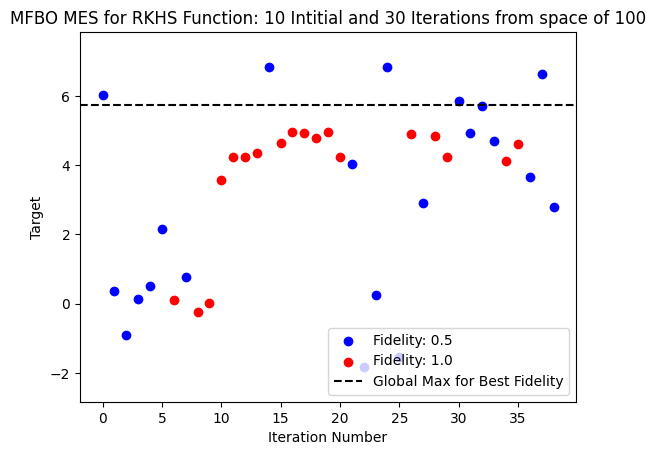

In [9]:
plot(train_x_full_mes, train_obj_mes, 'MFBO MES for RKHS Function: 10 Intitial and 30 Iterations from space of 100', domain)

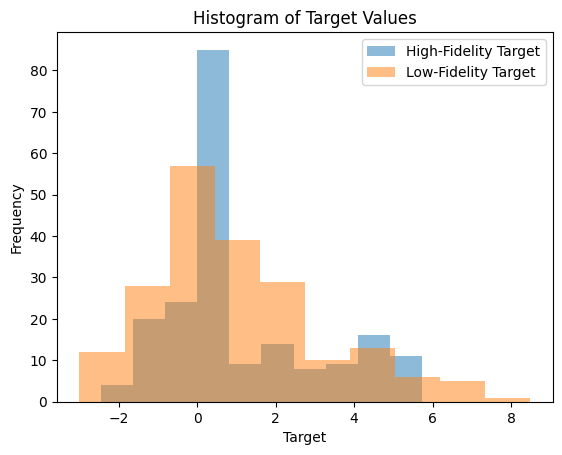

In [10]:
#Shows distribution of High-fidelity and Low-fidelity targets.
def plot_histogram(domain):
    high_fidelity = domain[np.where(domain[:, 1]==1.0)]
    low_fidelity = domain[np.where(domain[:, 1]==0.5)]
    plt.hist(high_fidelity[:, -1], label='High-Fidelity Target', bins=10, alpha=0.5)
    plt.hist(low_fidelity[:, -1], label='Low-Fidelity Target', bins=10, alpha=0.5)
    plt.title('Histogram of Target Values')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show() 

plot_histogram(domain)

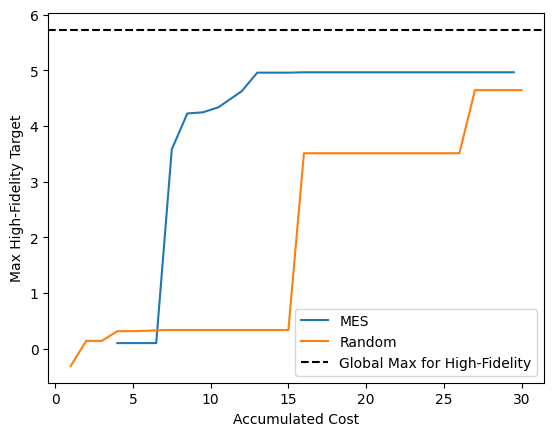

In [11]:
# Here we plot the maximum high-fidelity target reached so far with a given cost. 
def plot_cost(domain, dictionary): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        cumulative_cost_array = np.array(cumulative_cost)
        hf_indices = np.where(train_x_full[:, 1]==1.0)
        high_fidelity_obj = train_obj[np.where(train_x_full[:, 1]==1.0)].detach().numpy()
        accum_target = []
        for i in range(len(high_fidelity_obj)):
            accum_target.append(max(high_fidelity_obj[0:i+1]))

        plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=search_alg)    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.legend()

modelDict = {"MES": (train_x_full_mes, train_obj_mes, cumulative_cost_mes), "Random": (train_x_full_rand, train_obj_rand, cumulative_cost_rand) }    
plot_cost(domain, modelDict)

In [20]:
# Adding in batch functionality
def run_entire_cycle_batch(no_of_iterations, fileName, experiments, func):
    train_x_full_batch = []
    train_obj_batch = []
    cumulative_cost_batch = [] 
    index_store_batch = []
    for j in range(experiments):
        train_x_full, train_obj, domain, index_store, budget = setUpInitialData(fileName, 10)
        domain_X_only = domain[:, 0:-1]  
        for i in range(no_of_iterations):
            model = SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=1)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_mll(mll)  
            acquisitionScores = func(model=model, Xrpr=domain_X_only)
            sorted_acqusition_scores = acquisitionScores.argsort(descending=True)
            top_candidate, fidelity, evaluation = optimiseAcquisitionFunction(sorted_acqusition_scores, domain, train_x_full, index_store)
            budget.append(fidelity)
            train_x_full = torch.cat([train_x_full, torch.tensor([top_candidate, fidelity]).unsqueeze(0)])
            train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)])
        cumulative_cost = [budget[0]]
        for i in range(len(budget) - 1):
            cumulative_cost.append(cumulative_cost[-1] + budget[i+1])
        train_x_full_batch.append(train_x_full)
        train_obj_batch.append(train_obj)
        cumulative_cost_batch.append(cumulative_cost)
        index_store_batch.append(index_store)
    return train_x_full_batch, train_obj_batch, cumulative_cost_batch, index_store_batch

In [ ]:
N_ITER = 30
N_EXP = 4
fileName = 'SampleSpaces/20240606-114441.csv'

train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch = run_entire_cycle_batch(
    N_ITER,
    N_EXP,
    fileName, 
    runMes
    );

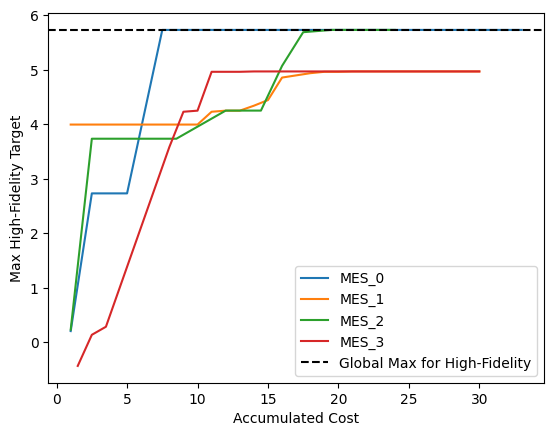

In [22]:
# This is code to debug the batch process a few cells later.
def plot_cost_batch_debug(domain, dictionary): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        for j in range(len(train_x_full)):
            cumulative_cost_array = np.array(cumulative_cost[j])
            hf_indices = np.where(train_x_full[j][:, 1]==1.0)
            high_fidelity_obj = train_obj[j][np.where(train_x_full[j][:, 1]==1.0)].detach().numpy()
            accum_target = []
            for i in range(len(high_fidelity_obj)):
                accum_target.append(max(high_fidelity_obj[0:i+1]))

            plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=f"{search_alg}_{j}")    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.legend()
searchDictBatch = {"MES": (train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch)}   
plot_cost_batch_debug(domain, searchDictBatch)

In [ ]:
searchDictBatch = {"MES": (train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch)}    
# print(train_x_full_mes_batch)
print(train_obj_mes_batch[0][np.where(train_x_full_mes_batch[0][:, -1]==1)])
print(train_obj_mes_batch[1]
      )

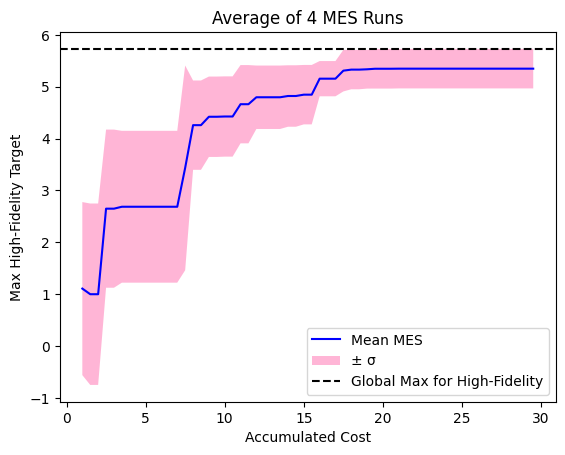

In [35]:
# Here we plot the mean maximum high-fidelity target reached so far with SD for a batch of experiments. 
def plot_cost_batch(domain, dictionary): 
    max_in_space= np.max(domain[np.where(domain[:, 1] == 1.0)])
    for search_alg in dictionary:
        aggregate_max_target = []
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        cost_range = list(np.arange(1,30,0.5))
        for j in range(len(train_x_full_batch)):
            cumulative_cost_array = np.array(cumulative_cost_batch[j])
            hf_indices = np.where(train_x_full_batch[j][:, 1]==1.0)
            high_fidelity_obj = train_obj_batch[j][np.where(train_x_full_batch[j][:, 1]==1.0)].detach().numpy().squeeze(-1)
            accum_target = []
            for i in range(len(high_fidelity_obj)):
                accum_target.append(max(high_fidelity_obj[0:i+1]))
            accum_target = np.array(accum_target)
            max_target = []
            for id, x in enumerate(cost_range):
                if x in cumulative_cost_array[ hf_indices ]:
                    max_target.append(accum_target[np.where(cumulative_cost_array[ hf_indices ] == x )[0]][0].item())
                elif id == 0:
                    max_target.append(0)
                else:
                    max_target.append(max_target[id-1])
            aggregate_max_target.append(max_target)
        maximum_aggregate_mean = np.mean(aggregate_max_target, axis = 0)
        maximum_aggregate_lowerbound = maximum_aggregate_mean - np.std(aggregate_max_target, axis = 0)
        maximum_aggregate_upperbound = maximum_aggregate_mean + np.std(aggregate_max_target, axis = 0)
        plt.plot(cost_range, maximum_aggregate_mean, label='Mean MES', color='blue')
        plt.fill_between(x=cost_range, y1=maximum_aggregate_lowerbound, y2=maximum_aggregate_upperbound, color="#FF6DAE", alpha=0.5, ec="None", label='\xb1 \u03C3')    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.title(f'Average of {N_EXP} MES Runs')
    plt.legend(loc='lower right')

plot_cost_batch(domain, searchDictBatch)